In [12]:
from dask.distributed import Client, LocalCluster

# Example: 4 workers, 1 thread each
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

print("Dashboard:", client.dashboard_link)


/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35405 instead
  warnings.warn(


Dashboard: http://127.0.0.1:35405/status


In [ ]:
# CLUSTER DEPLOYMENT ON CLOUDVENETO
from dask.distributed import Client, SSHCluster

cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    worker_options={
        "nprocs": 1,       # N. of processess per VM. CloudVeneto's large VM offers 4-core CPU, but for now we only spawn 1 process per VM
        "nthreads": 1      # N. of threads per process
    }
)

client = Client(cluster)


In [13]:
# check if everything went smoothly
print(client)
print(cluster)


<Client: 'tcp://127.0.0.1:38627' processes=4 threads=4, memory=5.79 GiB>
LocalCluster(52f72c90, 'tcp://127.0.0.1:38627', workers=4, threads=4, memory=5.79 GiB)


In [37]:
import dask.array as da
import dask
import numpy as np
import time
from scipy.linalg import solve_triangular 
from sklearn.datasets import fetch_california_housing

# Download California Housing dataset
data = fetch_california_housing(as_frame=True)

# Convert features into Dask Array (it's a matrix).
n_partition = 3        # number of partition in memory. We have 4 VMS (1 master + 3 workers), so let's start with just 3 partitions
length_partition = data.data.shape[0] // n_partition
X_da = da.from_array(data.data.values, chunks=(length_partition, data.data.shape[1]))

print("Number of Dask partitions:",  X_da.npartitions) 
print("Length of each partition:", length_partition, "rows")
print("Length of the whole dataset:", data.data.shape[0], "rows")


Number of Dask partitions: 3
Length of each partition: 6880 rows
Length of the whole dataset: 20640 rows


In [34]:
X_cached = X_da.rechunk((1_000_000, -1)).persist()

print(X_da)


dask.array<array, shape=(20640, 8), dtype=float64, chunksize=(6880, 8), chunktype=numpy.ndarray>


In [35]:
def indirect_serial(A, n_div):

    """
    Indirect TSQR (serial, NumPy).
    Splits A by rows into n_div blocks, computes local R_i via QR,
    reduces to global R by QR on the stacked R_i, then recovers Q = A R^{-1}.
    Returns (Q, R).
    """

    n_samp = A.shape[0]
    
    div_points = int(np.floor(n_samp/n_div))
    A_divided = []
    Ri = []
    
    A_divided = [A[div_points * i : div_points * (i + 1)] for i in range(n_div - 1)]
    A_divided.append(A[(n_div - 1) * div_points:, :])   # In the case n_samp wasn't divisible by n_div

    Ri = [np.linalg.qr(Ai, mode="reduced")[1] for Ai in A_divided]
    
    R_stack = np.concatenate(Ri, axis = 0)

    # Step 3. Stack R_i and compute global R

    _, R = np.linalg.qr(R_stack, mode="reduced")


    """try:
        I = np.eye(n, dtype=A.dtype)
        Rinv = solve_triangular(R, I, lower=False)
    except Exception:
        Rinv = np.linalg.inv(R)  # fallback if SciPy not available
    Q = A @ Rinv"""

    """
    np.linalg.inv(R) is numerically less stable than solving the triangular system.
    R is upper-triangular, so it is possible to try to use scipy.linalg.solve_triangular.
    """
    Q = A @ np.linalg.inv(R)


    return Q, R


def compute_R(block):
    # np.linalg.qr with mode='r' gives just the R matrix
    R = np.linalg.qr(block, mode="r")
    return R


def indirect_parallel(X_da):

    """
    Indirect TSQR with Dask.
    Input:
        X_da : Dask Array (m x n), chunked row-wise
    Output:
        R    : final global triangular factor (n x n, NumPy array on driver)
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """


    n_cols = X_da.shape[1]

    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
    # Now R_blocks is a stack of n x n matrices (one per partition)
    # Its shape is (#chunks * n, n)

    R_blocks.visualize(filename="fig/R_blocks_graph", format="png")
 

    #Dask has da.linalg.qr, but it assumes the whole array is large and chunked regularly.
    #To get the final global R, you must combine all the Ri
    #That means at some point, the data has to come together into a single place (can’t keep it sharded).
    # So we bring the data to the driver because it is very small, because it optimizes the uses of np.linalg.qr, we are gathering the small stuff
    R_stack = R_blocks.compute()   # NumPy array, shape (p*n, n)

    # Small QR on driver to combine them into the final R
    R = np.linalg.qr(R_stack, mode="r")
    # delay the computing of qr

    # Instead of materializing Q, compute a small R^{-1} (n x n).
    I = np.eye(n_cols, dtype=X_da.dtype)
    R_inv = solve_triangular(R, I, lower=False)  # stable

    # Broadcast Rinv to every chunk: Q = A @ R^{-1}
    Q_da = X_da @ R_inv   # still a Dask Array, lazy

    return Q_da, R      #Q_da because it is lazy, it is still a Dask array



def indirect_parallelR(X_da):

    """
    Indirect TSQR with Dask.
    Input:
        X_da : Dask Array (m x n), chunked row-wise
    Output:
        R    : final global triangular factor (n x n, NumPy array on driver)
    """


    n_cols = X_da.shape[1]

    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
   
    R_stack = R_blocks.compute()   # NumPy array, shape (p*n, n)

    R = np.linalg.qr(R_stack, mode="r")

    return R      #Q_da because it is lazy, it is still a Dask array




In [32]:
%%time

Q, R = indirect_serial(data.data.values, 50)
size = 20640 / 50 * 8 * 8 #rows_per_chunk × n_cols × 8 bytes
print("The size for each chunk is :", size/1e6, "Mb")


The size for each chunk is : 0.0264192 Mb
CPU times: user 18.7 ms, sys: 21.7 ms, total: 40.3 ms
Wall time: 25.9 ms


In [33]:
%%time

Q_da, R = indirect_parallel(X_da)   # X_da is already splitted into three partitions


print("Final R shape:", R.shape)  # (n, n), small
print("Q is lazy:", Q_da)         # Dask Array, not yet computed

print("Chunks:", X_da.chunks)
print("Number of partitions:", X_da.npartitions)
print("Total size [MB]:", X_da.nbytes / 1e6)
print("Chunk size [MB]:", X_da.nbytes / X_da.npartitions / 1e6)    # 10–100 MB

print("Shape:", X_da.shape)
print("Chunks:", X_da.chunks)
print("Partitions:", X_da.npartitions)
print("Total size [MB]:", X_da.nbytes/1e6)
print("Avg chunk [MB]:", (X_da.nbytes/X_da.npartitions)/1e6)


#print("Compact sanity check:", X_da.shape, "(m,n);", R_blocks.shape, "(n *n_partitions, n);", R.shape, "(n,n)" )


Final R shape: (8, 8)
Q is lazy: dask.array<getitem, shape=(20640, 8), dtype=float64, chunksize=(6880, 8), chunktype=numpy.ndarray>
Chunks: ((6880, 6880, 6880), (8,))
Number of partitions: 3
Total size [MB]: 1.32096
Chunk size [MB]: 0.44032
Shape: (20640, 8)
Chunks: ((6880, 6880, 6880), (8,))
Partitions: 3
Total size [MB]: 1.32096
Avg chunk [MB]: 0.44032
CPU times: user 73 ms, sys: 19.5 ms, total: 92.5 ms
Wall time: 135 ms


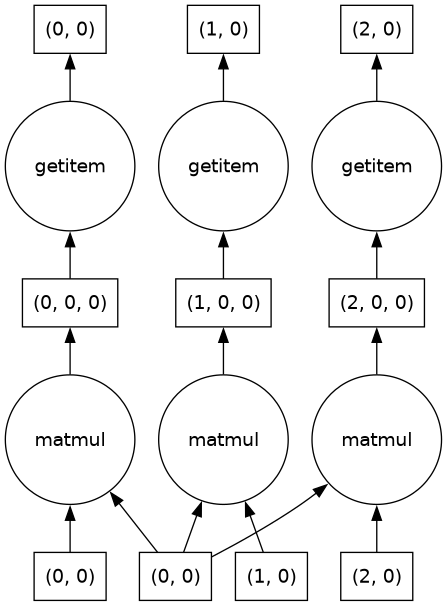

In [19]:

Q_da.visualize("fig/q_mul_graph.png")


In [24]:
def indirect_parallel_partially_delayed(X_da):

    """
    Indirect TSQR with Dask.
    Input:
        X_da : Dask Array (m x n), chunked row-wise
    Output:
        R    : final global triangular factor (n x n, NumPy array on driver)
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """


    n_cols = X_da.shape[1]

    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
    # Now R_blocks is a stack of n x n matrices (one per partition)
    # Its shape is (#chunks * n, n)

    R_blocks.visualize(filename="fig/R_blocks_graph", format="png")

    # 2) Convert blocks to delayed NumPy arrays, stack via delayed
    R_list = list(R_blocks.to_delayed().ravel())     # each is delayed np.ndarray (n x n)
    R_stack = dask.delayed(np.vstack)(R_list)        # delayed (p*n x n)


    R_da = dask.delayed(compute_R)(R_stack)      # delayed np.ndarray (n x n)

    # 4) Materialize small R on driver; solve for R^{-1}
    R = R_da.compute()                           # NumPy (n x n)
    I = np.eye(n_cols, dtype=X_da.dtype)
    R_inv = solve_triangular(R, I, lower=False)       # NumPy (n x n)

    # 5) Broadcast multiply (keep Q lazy)
    Q_da = X_da @ R_inv

    return Q_da, R      #Q_da because it is lazy, it is still a Dask array


def indirect_parallel_delayed(X_da):

    """
    Indirect TSQR with Dask.
    Input:
        X_da : Dask Array (m x n), chunked row-wise
    Output:
        R    : final global triangular factor (n x n, NumPy array on driver)
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """


    n_cols = X_da.shape[1]

    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
    # Now R_blocks is a stack of n x n matrices (one per partition)
    # Its shape is (#chunks * n, n)


    # 2) Convert blocks to delayed NumPy arrays, stack via delayed
    R_list = list(R_blocks.to_delayed().ravel())     # each is delayed np.ndarray (n x n)
    R_stack = dask.delayed(np.vstack)(R_list)        # delayed (p*n x n)
    

    R_delayed = dask.delayed(compute_R)(R_stack)      # delayed np.ndarray (n x n)

    # 3) Turn the small delayed R into a Dask Array (single (n,n) chunk)
    R_da = da.from_delayed(R_delayed, shape=(n_cols, n_cols), dtype=X_da.dtype)

    # 4) Materialize small R on driver; solve for R^{-1}
    I = np.eye(n_cols, dtype=X_da.dtype)

    # compute R^{-1} lazily
    R_inv_delayed = dask.delayed(solve_triangular)(R_delayed, I, lower=False)
    R_inv_da = da.from_delayed(R_inv_delayed, shape=(n_cols, n_cols), dtype=X_da.dtype)

    # 5) Broadcast multiply (keep Q lazy)
    Q_da = X_da @ R_inv_da

    return Q_da, R_da      #Q_da because it is lazy, it is still a Dask array


In [25]:
%%time

Q_da_part, R_da_part = indirect_parallel_partially_delayed(X_da)   # X_da is already splitted into three partitions


CPU times: user 79 ms, sys: 12.6 ms, total: 91.6 ms
Wall time: 134 ms


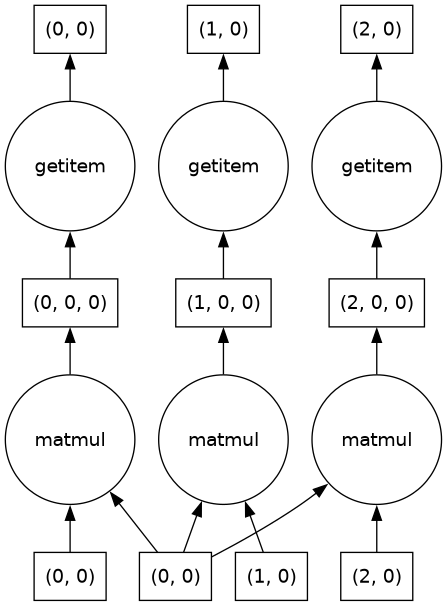

In [ ]:
Q_da_part.visualize("fig/q_part_graph.png")


In [ ]:
%%time

Q_da_full, R_da_full = indirect_parallel_delayed(X_da)   # X_da is already splitted into three partitions


CPU times: user 9.42 ms, sys: 10.1 ms, total: 19.6 ms
Wall time: 19.4 ms


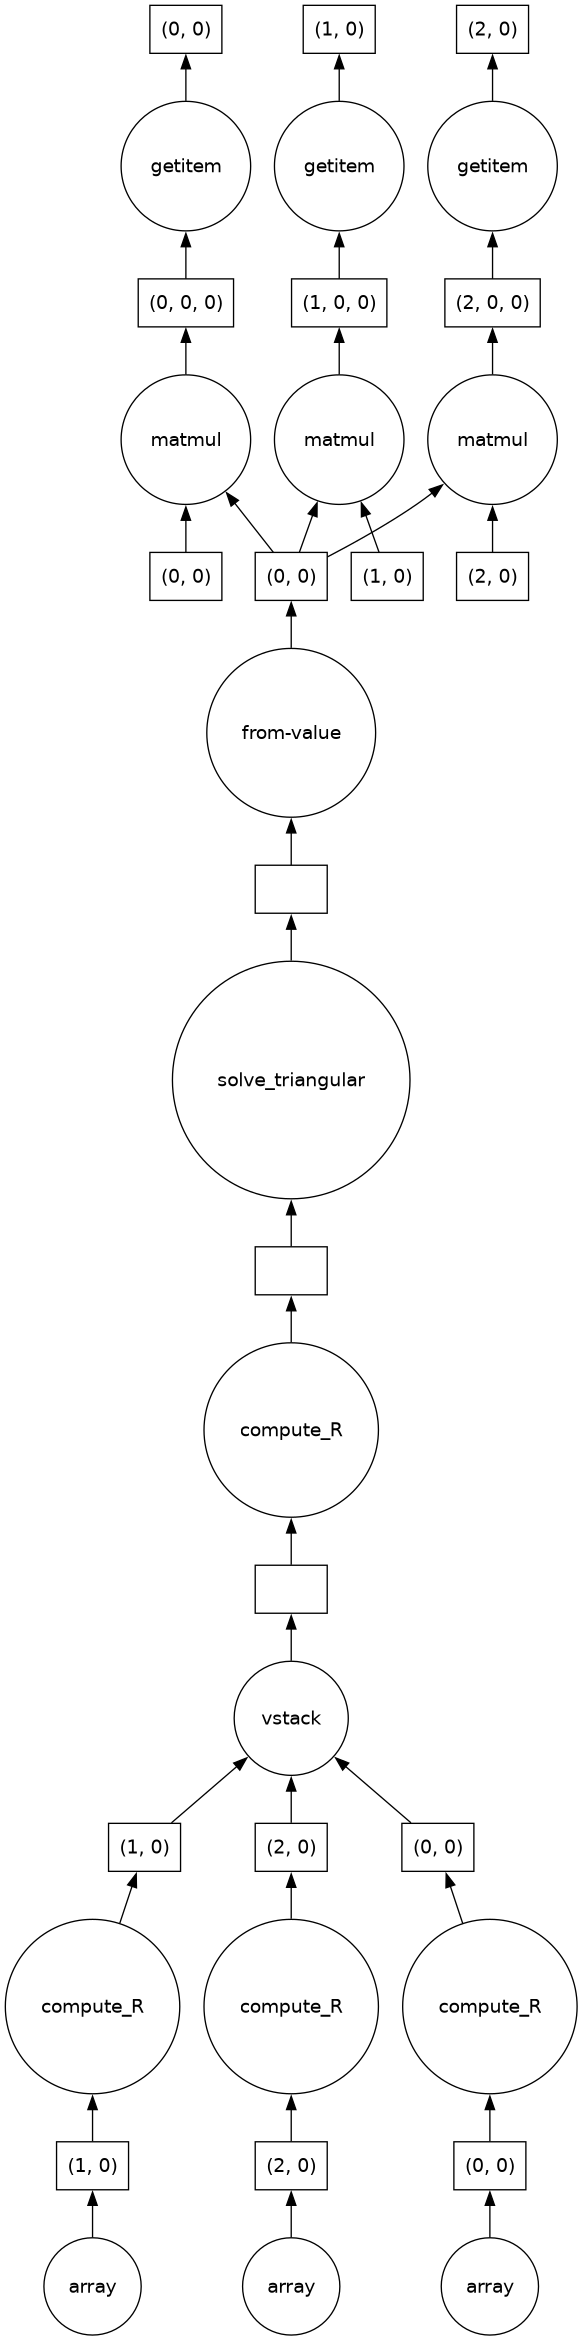

In [ ]:

Q_da_full.visualize("fig/q_full_graph.png")    



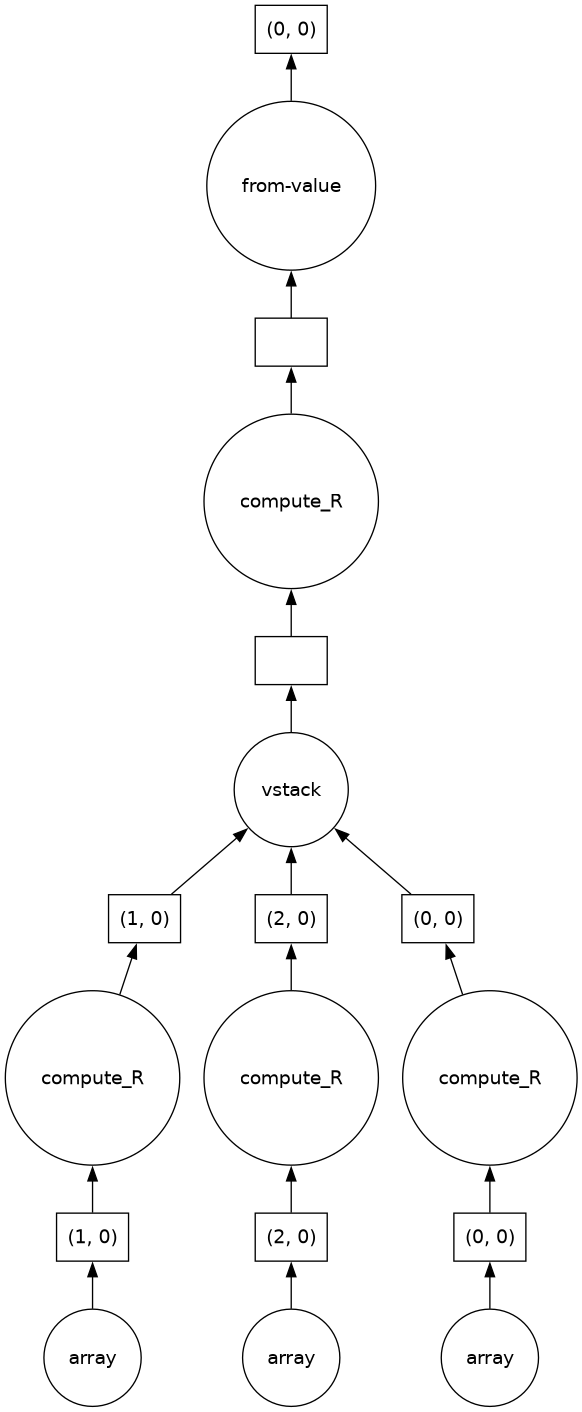

In [ ]:
R_da_full.visualize("fig/r_full_graph.png")    


In [48]:
def indirect_parallel_optimized(X_da):

    """
    Indirect TSQR with Dask.
    Input:
        X_da : Dask Array (m x n), chunked row-wise
    Output:
        R    : final global triangular factor (n x n, NumPy array on driver)
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """


    n_cols = X_da.shape[1]

    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
    # Now R_blocks is a stack of n x n matrices (one per partition)
    # Its shape is (#chunks * n, n)

    R_blocks.visualize(filename="fig/R_blocks_graph", format="png")
 

    #Dask has da.linalg.qr, but it assumes the whole array is large and chunked regularly.
    #To get the final global R, you must combine all the Ri
    #That means at some point, the data has to come together into a single place (can’t keep it sharded).
    # So we bring the data to the driver because it is very small, because it optimizes the uses of np.linalg.qr, we are gathering the small stuff
    R_stack = R_blocks.compute()   # NumPy array, shape (p*n, n)

    # Small QR on driver to combine them into the final R
    R = np.linalg.qr(R_stack, mode="r")
    # delay the computing of qr

    # Instead of materializing Q, compute a small R^{-1} (n x n).
    I = np.eye(n_cols, dtype=X_da.dtype)
    R_inv = solve_triangular(R, I, lower=False)  # stable

    Rinv_da = da.from_array(R_inv, chunks=(R_inv.shape[0], R_inv.shape[1]))
    Q_da = X_da @ Rinv_da

    return Q_da, R      #Q_da because it is lazy, it is still a Dask array




In [ ]:
%%time

Q_da_opt, R_da_opt = indirect_parallel_optimized(X_da)   # X_da is already splitted into three partitions


CPU times: user 118 ms, sys: 33.1 ms, total: 151 ms
Wall time: 207 ms


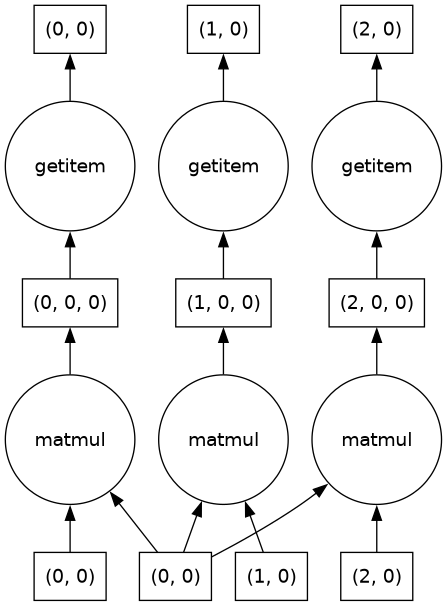

In [ ]:

Q_da_opt.visualize("fig/q_full_graph.png")    


In [ ]:
# not-delayed version
start = time.perf_counter()
Q_nd, R_nd = indirect_parallel(X_cached)  # returns Q_da, R (NumPy)
_ = R_nd  # already materialized
t_nd_R = time.perf_counter() - start

# optimized not-delayed version
start = time.perf_counter()
Q_po, R_po = indirect_parallel_optimized(X_cached)  # returns Q_da (Dask), R_da (Dask)
_ = R_po  # already materialized
t_po_R = time.perf_counter() - start

# partially-delayed version
start = time.perf_counter()
Q_pd, R_pd = indirect_parallel_partially_delayed(X_cached)  # returns Q_da (Dask), R (NumPy)
_ = R_pd  # already materialized inside the function
t_pd_R = time.perf_counter() - start

# fully-delayed version
start = time.perf_counter()
Q_fd, R_fd = indirect_parallel_delayed(X_cached)  # returns Q_da (Dask), R_da (Dask)
_ = R_fd.compute()  # FORCE the same final R compute
t_fd_R = time.perf_counter() - start


print(f"R time — not-delayed: {t_nd_R:.3f}s | optimized: {t_po_R:.3f}s | partial: {t_pd_R:.3f}s | full-delayed: {t_fd_R:.3f}s")


R time — not-delayed: 0.091s | optimized: 0.058s | partial: 0.055s | full-delayed: 0.028s


In [ ]:
# e.g., apply Q to a random vector and compute the norm — same workload for all
v = np.random.randn(X_cached.shape[1]).astype(X_cached.dtype)

def time_Q_apply(Q_da, v):
    start = time.perf_counter()
    val = da.linalg.norm(Q_da @ v).compute()  # triggers the matmul + reduction
    end = time.perf_counter()
    return end - start, val

t_nd_Q, val_nd = time_Q_apply(Q_nd, v)
t_po_Q, val_po = time_Q_apply(Q_po, v)
t_pd_Q, val_pd = time_Q_apply(Q_pd, v)
t_fd_Q, val_fd = time_Q_apply(Q_fd, v)

print(f"Q apply — not-delayed: {t_nd_Q:.3f}s | partial: {t_po_Q:.3f}s | partial: {t_pd_Q:.3f}s | full-delayed: {t_fd_Q:.3f}s")


Q apply — not-delayed: 0.118s | partial: 0.115s | partial: 0.048s | full-delayed: 0.066s


In [ ]:
# create again a cluster
# CLUSTER DEPLOYMENT ON CLOUDVENETO
client.close()   # close the previous one
cluster.close()  # close the previous one

cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    worker_options={
        "nprocs": 4,        # Now we use all 4 cores -> 12 workers
        "nthreads": 1       # We use 1 threads. Following Dask documentation, however, Numpy should release well the GIL lock thus we could use more than 1 thread. 
    }
)

client = Client(cluster)


In [ ]:
print(client)
print(cluster)


In [ ]:
cluster


In [ ]:
import dask.dataframe as dd
import os

os.chdir("/home/ubuntu") 
path_HIGGS = os.getcwd() + "/datasets/HIGGS.csv"
# A huge dataset
df = dd.read_csv(path_HIGGS, header=None, blocksize="200MB")    # The block size can be customized, let's start with 200 MB
X_df = df.iloc[:, 1:] 
X_da = X_df.to_dask_array(lengths=True)


In [1]:
#Let's print it
X_da


NameError: name 'X_da' is not defined

In [ ]:

# Print the number of partition
X_da.npartitions


In [ ]:

%%time

Q_da, R = indirect_parallel(X_da)


In [ ]:
%%time
R = indirect_parallelR(X_da)


In [ ]:
# Rechunk to ~1M rows per block (~100 MB) so each worker gets a good-sized task
X_da_cached = X_da.rechunk((1_000_000, -1)).persist()

# First persist actually loads CSV into memory on workers
# This itself will take a few seconds (same cost as run 1)


In [ ]:
%%time
Q_da2, R2 = indirect_parallel(X_da_cached)   # Now works from cached chunks in RAM


In [ ]:
%%time
R = indirect_parallelR(X_da_cached)
